# Deep Learning - Imbalanced Dataset 

Nombre: __Adonis González__

El siguiente código carga los paquetes y paths necesarios

In [1]:
import sys  
sys.path.insert(0, '../src/')

from imports import *
from plot_functions import * 
from model_function import * 

Versions y devices:

In [2]:
print("TF version   : ", tf.__version__)
print("Keras version   : ", keras.__version__)

print("GPU available: ", tf.config.list_physical_devices('GPU'))
local_prot = device_lib.list_local_devices()
print([x.physical_device_desc for x in local_prot if x.device_type == 'GPU'])

TF version   :  2.4.1
Keras version   :  2.4.3
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5']


Paths sources:

In [3]:
ROOT_DIR = os.path.abspath("../")
data_dir = os.path.join(ROOT_DIR, "data")
train = os.path.join(data_dir, "m0002_train.csv")
test = os.path.join(data_dir, "m0002_X_test.csv")

## 1. Exploración y preprocesado de los datos

En este apartado exploraremos la base de datos y prepararemos la carga de estos.

Las redes neuronales artificiales, como el resto de modelos de aprendizaje automático, requieren que los datos de entrada estén en un formato específico para poder trabajar de forma correcta. Concretamente estos deben estar en formato numérico y se recomienda que estén estandarizados. Además, en caso de haber más de dos clases será recomendable también binarizarlas.

Cargamos el conjunto de datos (train y test):

In [4]:
# read as panda dataframe
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

Printamos las primeras filas para los dos dataframes:

In [5]:
df_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,target
0,-3.538199,-1.759332,3.394096,1.505131,-2.203811,0.419645,1.448805,-0.197721,0.176068,0.895649,0.446218,-0.497800,0
1,-1.436324,-1.066339,1.195572,0.849122,-1.175591,1.822787,-1.041183,0.544819,-0.596720,-0.433713,0.141162,0.396984,0
2,1.751052,-1.554701,-1.434972,-3.385970,2.696068,0.404870,0.033898,3.496938,0.668955,2.130898,-0.645976,0.451687,0
3,-0.972946,-2.574483,-0.931830,-0.115397,-1.160457,1.327775,-1.620851,3.349718,1.982310,0.654206,1.415909,1.352655,0
4,2.868430,-3.339835,-0.128426,-3.416830,1.522037,0.124241,-1.460393,4.479508,0.492836,-0.657295,-0.395183,0.046248,0


In [6]:
df_test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
0,-3.625737,-0.448304,0.686735,-0.153474,-1.846432,2.182056,1.346177,1.927974,-1.044868,-1.079276,-1.358775,-0.783192
1,2.227734,-1.825516,-0.781210,-2.999474,-0.630940,0.539708,-1.478162,4.493366,-1.169011,-1.231165,-0.648653,-1.203637
2,0.498324,-3.890139,-2.096111,5.336336,-2.502190,1.559121,-8.026406,0.420241,0.962498,-1.775562,-0.324233,-0.984230
3,-1.582960,-1.851163,1.605599,2.476061,-1.945382,0.545616,-1.506179,-0.478057,-0.362259,0.676045,0.056187,-0.691105
4,-0.161315,-0.434083,-2.287770,-0.905045,0.229371,-0.267126,0.249771,2.100225,-1.254606,-0.175216,1.014838,-0.956751


Miramos la dimensión total del dataset de train:

In [7]:
df_train.shape

(70000, 13)

Miramos la variable objetiva o `target` cuántos valores diferentes tenemos:

In [8]:
len(set(df_train["target"]))

5

Se muestra un histograma con el balance del dataset entre sus clases:

<AxesSubplot:>

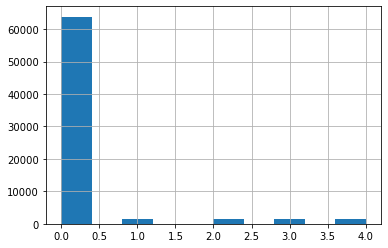

In [9]:
df_train.target.hist()

Se trata de un dataset completamente desbalanceado entre sus clases, en el histograma anterior se puede apreciar el número total de instacias por cada clase, siendo la clase 0 la dominante.

Miramos los tipos de variables que tenemos, para tener en cuenta si es necesario una transformación.

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      70000 non-null  float64
 1   f2      70000 non-null  float64
 2   f3      70000 non-null  float64
 3   f4      70000 non-null  float64
 4   f5      70000 non-null  float64
 5   f6      70000 non-null  float64
 6   f7      70000 non-null  float64
 7   f8      70000 non-null  float64
 8   f9      70000 non-null  float64
 9   f10     70000 non-null  float64
 10  f11     70000 non-null  float64
 11  f12     70000 non-null  float64
 12  target  70000 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 6.9 MB


Miramos si tenemos nulos:

In [11]:
for key,value in df_train.isnull().sum().iteritems():
    if value > 0:
        print(key," -->",value)

No hay datos nulos.

In [12]:
# fig, ax = plt.subplots(figsize=(15,5))
# sns.heatmap(df.isnull(), cbar=False, vmin=0, vmax=0.7, ax=ax)

<br>

__Random under-sampling__

In [13]:
# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]
df_class_2 = df_train[df_train['target'] == 2]
df_class_3 = df_train[df_train['target'] == 3]
df_class_4 = df_train[df_train['target'] == 4]

print("0: " + str(len(df_class_0)))
print("1: " + str(len(df_class_1)))
print("2: " + str(len(df_class_2)))
print("3: " + str(len(df_class_3)))
print("2: " + str(len(df_class_2)))
print("4: " + str(len(df_class_4)))

0: 63824
1: 1506
2: 1521
3: 1564
2: 1521
4: 1585


In [14]:
df_class_0_under = df_class_0.sample(len(df_class_4))
df_test_under = pd.concat([df_class_0_under, df_class_1, df_class_2, df_class_3, df_class_4], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

Random under-sampling:
4    1585
0    1585
3    1564
2    1521
1    1506
Name: target, dtype: int64


Cambiamos los datos de pandas dataframe a numpy array:

In [15]:
features = df_test_under.iloc[:, :-1].values
labels = df_test_under.iloc[:, -1:].values

<BR>
    
__Se estandardiza y binarizara debidamente los datos__

In [16]:
# StandardScaler
standScaler = StandardScaler()
features = standScaler.fit_transform(features)

# OneHotEncoder
oneHotEncoder = OneHotEncoder()
labels = oneHotEncoder.fit_transform(labels).toarray()

Finalmente, en este apartado dividimos el conjunto de datos en 80% para entrenamiento y 20% para test.

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=123)

## 2. Models

En este apartado, vamos a entrenar y evaluar modelos muy sencillos completamente conectados para establecer unos resultados de referencia con diferentes optimizados y learning rates.

In [18]:
neurons = [[64, 32, 10, 8]] #we can add other hidden layer in this list
learningRate = [0.001, 0.01, 0.05, 0.1]
optimizer = ['Adam', 'SGD', 'Adadelta', 'Adagrad']
EPOCHS = 10

In [19]:
hists = []
models = []
for i in optimizer:
    histTmp = []
    for j in learningRate:
        model = create_model(neurons[0], features.shape[1], labels.shape[1])
        model = compile_model(model, optimizer=i, loss = 'categorial_c', lr = j)
        hist = model.fit(train_x, train_y, epochs=EPOCHS, validation_data=(test_x, test_y), verbose=0)
        histTmp.append(hist.history['accuracy'][-1])
        models.append(model)
    hists.append(histTmp)

model compile using (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000016E9B8E20A0>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x0000016E9B90E490>, 0.001)
model compile using (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001707EE9CE20>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x000001707EE9CC70>, 0.01)
model compile using (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000017086D429A0>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x0000017086D689A0>, 0.05)
model compile using (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001708CDEDE50>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x000001708CDFD970>, 0.1)
model compile using (<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x000001708E17BD30>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x000001708E17BE80>, 0.001)
model compile using (<t

In [20]:
# weight class aproach
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(features),
#                                                  features)
# class_weight = {0: 1.,
#                 1: 5,
#                 2: 3,
#                 3: 3,
#                 4: 3}

## 3. Evaluación y resultados

### 3.1 Resultados en set de validation 

<br>

Se selecciona el mejor modelo:

In [21]:
 #check max mean accuracy for each optimizer and lr
hist_mean = np.mean(hists, axis = 1)
best_hist_mean = max(hist_mean)
index_hist_mean, = np.where(hist_mean == best_hist_mean) 
i = index_hist_mean[0]
print(hists[i])
lr_max = max(hists[i])
index_lr = hists[i].index(lr_max)
print(index_lr) 

[0.30251288414001465, 0.6063144207000732, 0.7116623520851135, 0.7740013003349304]
3


0 <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000016E9B8E20A0> LR:0.001


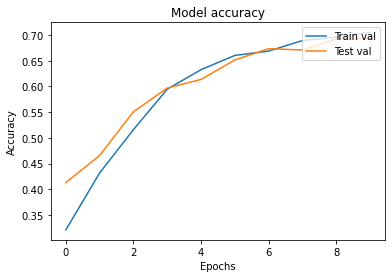

1 <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001707EE9CE20> LR:0.01


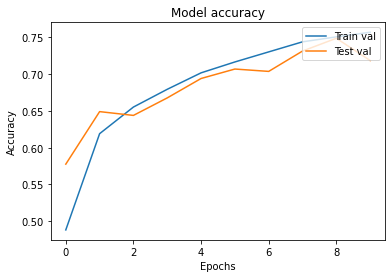

2 <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000017086D429A0> LR:0.05


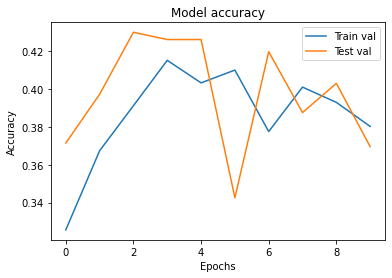

3 <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001708CDEDE50> LR:0.1


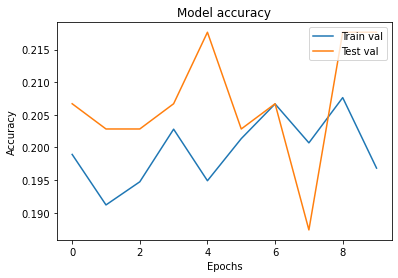

4 <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x000001708E17BD30> LR:0.001


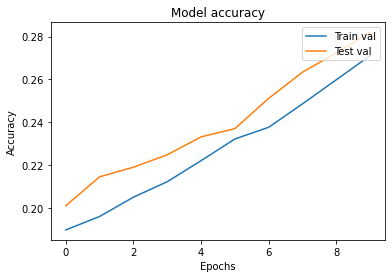

5 <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x00000170937D6940> LR:0.01


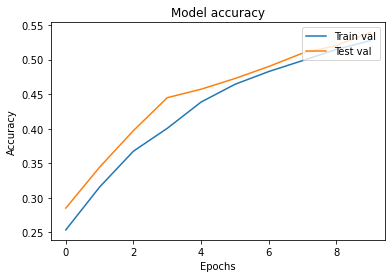

6 <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x0000017093BB8DF0> LR:0.05


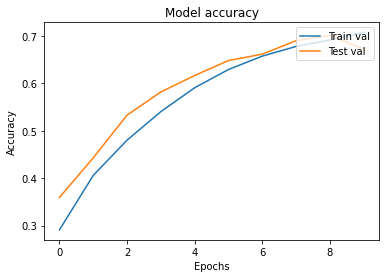

7 <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x00000170937FE6D0> LR:0.1


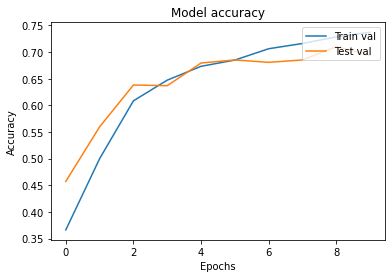

8 <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001709513EF40> LR:0.001


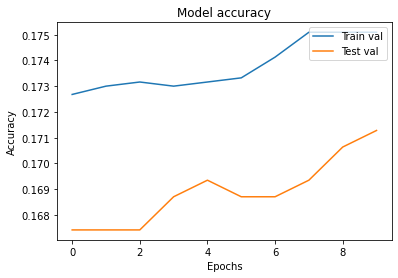

9 <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000017096568B20> LR:0.01


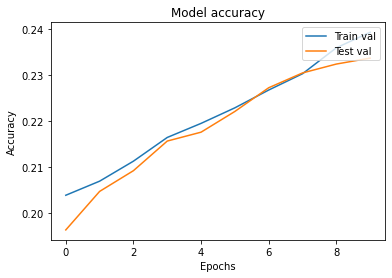

10 <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x00000170969CB7C0> LR:0.05


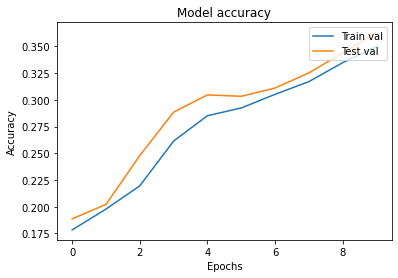

11 <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000017097DDB370> LR:0.1


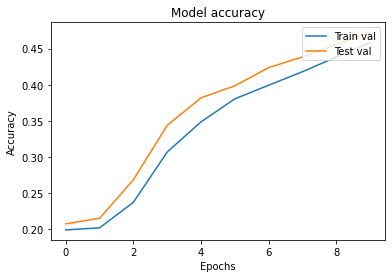

12 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000017086E99520> LR:0.001


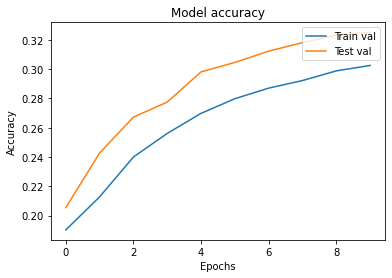

13 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000017099345BB0> LR:0.01


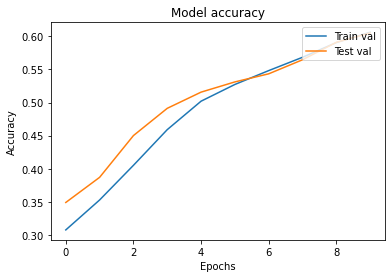

14 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000017099768E80> LR:0.05


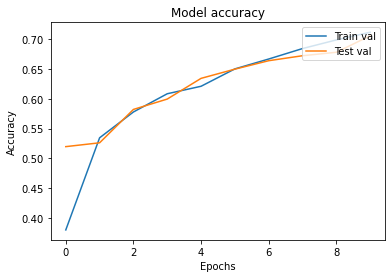

15 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x000001709AB6BC70> LR:0.1


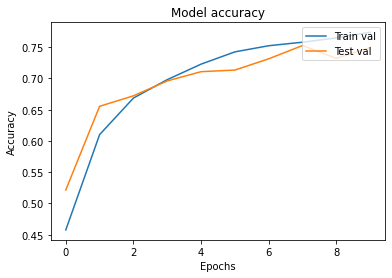

In [22]:
# just to see every trained model
import keras.backend as K
for i in range(0, len(models)):
    print(str(i) + " " + str(models[i].optimizer) + " LR:" + str(K.eval(models[i].optimizer.lr)))
    plot_accuracy(models[i].history)

Mostramos las gráficas de accuracy y loss

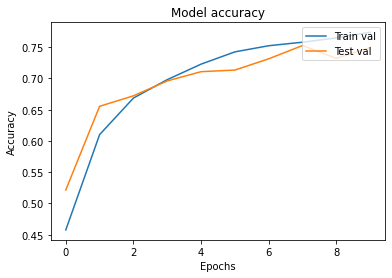

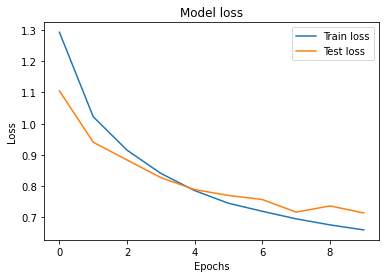

In [23]:
plot_accuracy(models[15].history)
plot_loss(models[15].history)

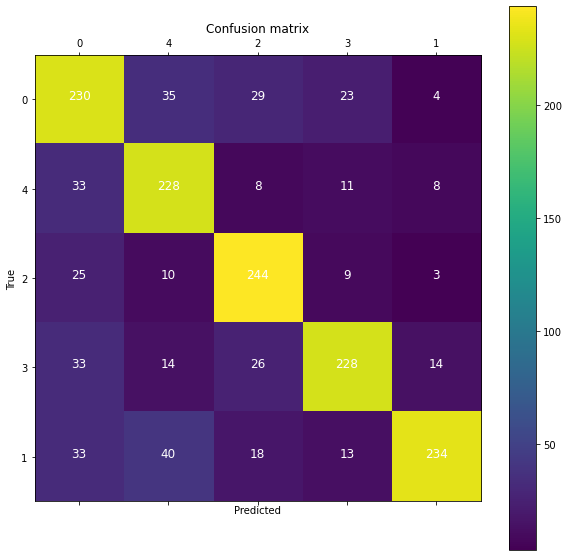

In [24]:
predictions = models[15].predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1),  predictions.argmax(axis=1))
plot_cm(cm, df_train['target'].unique().tolist())

In [25]:
print(f'\n Report:\n {classification_report(test_y.argmax(axis=1), predictions.argmax(axis=1))}')


 Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68       321
           1       0.70      0.79      0.74       288
           2       0.75      0.84      0.79       291
           3       0.80      0.72      0.76       315
           4       0.89      0.69      0.78       338

    accuracy                           0.75      1553
   macro avg       0.76      0.75      0.75      1553
weighted avg       0.76      0.75      0.75      1553



### 3.2 Predicciones del set de test

Se estadariza el set de test:

In [26]:
standScaler_test = StandardScaler()
features_test = standScaler_test.fit_transform(df_test)

Se predice:

In [27]:
predicciones = models[15].predict(features_test,)

Se guarda los resultados en csv:

In [30]:
result_file = os.path.join(data_dir, "results.csv")

In [31]:
results=pd.DataFrame({"results":predicciones.argmax(axis=1)})
results.to_csv(result_file,index=False)

<br>

In [32]:
results.results.value_counts()

0    15284
1     6646
3     3013
4     2579
2     2478
Name: results, dtype: int64